# Assignment Applied Machine Learning BSc IK 

## Notebook made by

**Gebruik graag dit formaat**

* Voor de namen:  voornaam rest van je naam, voornaam rest van je naam,....
* je studentnummers: hetzelfde: scheidt met `,`
* je emails: hetzelfde: scheidt met `,`
* voor je groep: **alleen de hoofdletter** (iets als  `A` of `B` dus)

__Namen__: 

__Emails__: 

__Student ids__ : 

__Groep__ : VervangMijDoorEenHoofdletter

## Toelichting

* Een aantal opgaven worden automatisch nagekeken. Bij vrijwel alle opdrachten staan er een paar tests onder de opdracht, dit is voornamelijk om te zorgen dat je de juiste type output geeft. Dit zijn dus *NIET* alle tests, die komen er bij het graden nog bij.
* Elke vraag is 1 punt waard, tenzij anders aangegeven. Soms is die punt onderverdeeld in deelpunten, maar niet altijd. 

## Voor het inleveren!

* Pas niet de cellen aan, vooral niet die je niet kunt editen. Dit levert problemen op bij nakijken. Twijfel je of je per ongeluk iets hebt gewijzigd, kopieer dan bij inleveren je antwoorden naar een nieuw bestand, zodat het niet fout kan gaan.

* Zorg dat de code goed runt van boven naar beneden, verifieer dat door boven in Kernel -> Restart & Run All uit te voeren

## Na het inleveren!

* Het gebeurt erg vaak dat mensen een "leeg bestand" inleveren. Vaak een andere versie van de opgave die nog ergens op je computer rondslingerde. Zonde van al je werk toch!
* Dus, lever **minstens een half uur voor tijd in**. Download dan wat je hebt ingeleverd op Canvas. Geef het een andere naam om verwarring te voorkomen. En draai alle cellen, en bekijk het. Geen syntax fouten? Alle vragen gemaakt? Dan zit het vast wel goed, en hoef je niet in de zenuwen te zitten.

# Applied Machine Learning W3

In the assignment for this week the focus will be on evaluation, where we take a look at confusion matrices, different metrics, and evaluation techniques such as cross validation and confidence intervals. As always, the exercises are mostly independent of each other, so if you get stuck somewhere, try doing a different part of the assignment, and come back to it later.

## Index

1. [Confusion Matrices](#conf_mat)
2. [Evaluation DIY](#eval1)
3. [Evluation with sklearn](#eval2)
4. [Cross Validation & Confidence Intervals](#cross_val)
5. [Baselines](#baselines)
6. [More Theory Questions](#theory)
7. [contagiousness Vs. Deadliness](#contag)

In [6]:
import os
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns

# testing
from nose.tools import assert_count_equal, assert_equal, assert_almost_equals
from numpy.testing import *
from numpy.testing import assert_equal
from pandas.testing import assert_frame_equal

# Please do not remove this: 
np.random.seed(31415)

<a id="conf_mat" />

# Confusion Matrix

In the class we looked at the following example Confusion Matrix with multiple classes:


* example  with 3 classes, N=1000
    * priors 700,200,100
    * diagonal : 600,50,10
    * predicted classes: 900,80,20
* Compute, precision, recall, F1 per class and  accuracy, macro values, weighted values over all classes.

## Your turn

* Create an example yourself, with maybe more classes and completely different numbers.
* Compute precision and recall per class alongside the table, indicate very very clearly what you are doing, and the order of things.
* Do it on paper with pencil and nice colors, make a photo, put it on the web, and create a hyperlink in the answer cell to your picture(s).

YOUR ANSWER HERE

<a id="eval1" />

# Evaluating a model

In this exercise we will be creating a complete ML pipeline where we load in a dataset, prepare it for classification by splitting it in train and test, run a classifier, and evaluate the results of this classifier.

We start by loading in the dataset, this code is already given for you.


In [7]:
def loadfile():
    if 'faults.csv.gz' in os.listdir():
        return 'faults.csv.gz'
    elif os.path.exists('../../data/Week1/'):
        return '../../data/Week3/faults.csv.gz'
    elif os.path.exists('../../../data/Week1/'):
        return '../../../data/Week3/faults.csv.gz'
    
df= pd.read_csv(loadfile())
print(df.shape)
df.head()

(1941, 34)


,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,42,50,270900,270944,267,17,44,24220,76,108,...,0.8182,-0.2913,0.5822,1,0,0,0,0,0,0
1,645,651,2538079,2538108,108,10,30,11397,84,123,...,0.7931,-0.1756,0.2984,1,0,0,0,0,0,0
2,829,835,1553913,1553931,71,8,19,7972,99,125,...,0.6667,-0.1228,0.2150,1,0,0,0,0,0,0
3,853,860,369370,369415,176,13,45,18996,99,126,...,0.8444,-0.1568,0.5212,1,0,0,0,0,0,0
4,1289,1306,498078,498335,2409,60,260,246930,37,126,...,0.9338,-0.1992,1.0000,1,0,0,0,0,0,0


The above dataframe contains data about the faults of machines. It is a multiclass classification problem with 6 fault classes and a 7th "other" class. It has 27 explanatory variables. Let's make a piechart of the data so that we can get a bit of a feel for the data.

Other_Faults    673
Bumps           402
K_Scatch        391
Z_Scratch       190
Pastry          158
Stains           72
Dirtiness        55
dtype: int64

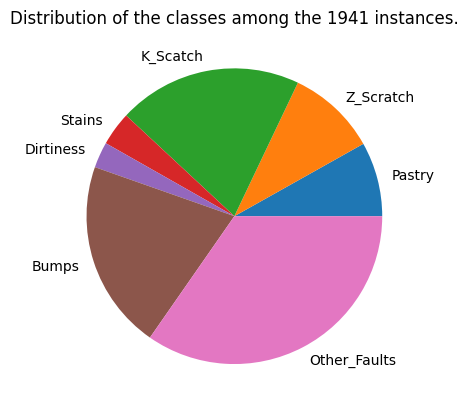

In [8]:
classes= ['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains',
       'Dirtiness', 'Bumps', 'Other_Faults']
df[classes].sum().plot(kind='pie', title='Distribution of the classes among the 1941 instances.');
df[classes].sum().sort_values(ascending=False)

Next up is actually running the experiment, which we are going to to in the steps provided below.

### Start up
1. Add a column `target` to `df` which contains the label names from the `classes` as values and a row has label `X` as value in that column iff `df[X]==1`. (maybe there is a `numpy` function you can use?)
2. Drop the original columns of the labels from the dataframe. 
3. Do a stratified 70-30 data train test split. 
    * Indicate and check visually that the data is split stratified, so each class also has a 70-30 split.
4. Create `y_pred` using KNN. You may want to normalize the data first.

### Evaluate

1. Create the confusion table based on `y_pred` and `y_test` from scratch, that is not using any `sklearn` functions. 
    2. Also show it nicely using `sns.heatmap`. 
2. Compute precision, recall and F1 for each label.
3. Compute accuracy.
4. Compute Macro, micro and weighted versions of precision, recall and F1.
5. Create at least two non-learned rule based baseline predictions, compute evaluation metrics and put these together with the scores for your KNN model into a clear table.

### Starting up

In [9]:
print(df[20:])

      X_Minimum  X_Maximum  Y_Minimum  Y_Maximum  Pixels_Areas  X_Perimeter   
20           17         28      42683      42717           284           18  \
21           43         52      86284      86313           153           13   
22           63         72     115485     115504           106           10   
23           82         92     149044     149083           264           15   
24           75         84     184350     184383           201           17   
...         ...        ...        ...        ...           ...          ...   
1936        249        277     325780     325796           273           54   
1937        144        175     340581     340598           287           44   
1938        145        174     386779     386794           292           40   
1939        137        170     422497     422528           419           97   
1940       1261       1281      87951      87967           103           26   

      Y_Perimeter  Sum_of_Luminosity  Minimum_of_Lu

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
1936    0.0
1937    0.0
1938    0.0
1939    0.0
1940    0.0
Name: target, Length: 1941, dtype: float64
['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']
      X_Minimum  X_Maximum  Y_Minimum  Y_Maximum  Pixels_Areas  X_Perimeter   
0            42         50     270900     270944           267           17  \
1           645        651    2538079    2538108           108           10   
2           829        835    1553913    1553931            71            8   
3           853        860     369370     369415           176           13   
4          1289       1306     498078     498335          2409           60   
...         ...        ...        ...        ...           ...          ...   
1936        249        277     325780     325796           273           54   
1937        144        175     340581     340598           287           44   
1938        145        174    

target
6    673
5    402
2    391
1    190
0    158
3     72
4     55
Name: count, dtype: int64

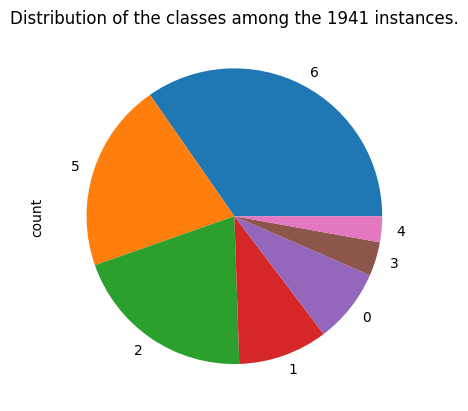

In [10]:
from sklearn.model_selection import train_test_split
# start by adding the new column

'''Add a column target to df which contains the label names from the classes as values and a row has label X as'''
''''value in that column iff df[X]==1. (maybe there is a numpy function you can use?)'''

# Fill in the right code in the line below

a = classes
df['target'] = np.zeros(len(df))
print(df['target'])
print(a)
#df['target'].iloc[:len(a)] = a

# voeg de appopriate class naam toe aan de target column, als de waarde van een van
# van de andere columns overeenkomt met het getal tussen 1 en 6
i = 0
for clas in classes:
    df.loc[df[clas] == 1, 'target'] = int(i)
    i = i + 1
new_df = df.drop(classes, axis=1)
new_df['target'] = new_df['target'].astype(int)
print(new_df)

# after adding the column, make matrices of the data for easy use

#X_train, X_test, y_train, y_test = train_test_split( new_df['target'], new_df.drop('target', axis=1), test_size=0.4, random_state=0, stratify=new_df['target'])

faults_X, faults_y = np.array(new_df.iloc[:, :-1]), np.array(new_df['target'])

T=pd.Series(new_df.target).value_counts()
T.plot(kind='pie', title='Distribution of the classes among the 1941 instances.');
T

In [11]:
assert_equal(new_df['target'].min(), 0)
assert_equal(new_df['target'].max(), 6)

Now that we have added the target column to the data we can create the train test split of the data, you may use `sklearn` for this.

In [12]:
# start up split
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(new_df.drop('target', axis=1), new_df['target'], test_size=0.3, train_size= 0.7, random_state=0, stratify=new_df['target'])

#print(test_y)
print(test_X)
#print(train_y)


#WRITE YOUR CODE HERE

      X_Minimum  X_Maximum  Y_Minimum  Y_Maximum  Pixels_Areas  X_Perimeter   
35          733        745    3957796    3957839           367           16  \
296          34         48    2044448    2044475           197           38   
1640        462        472   10369596   10369620           150           17   
925         213        223     625577     625588            87           16   
613          41        213    1637218    1637282          6206          257   
...         ...        ...        ...        ...           ...          ...   
1611        787        798    2887288    2887307           137           21   
649          43        218    2087881    2087946          6515          222   
999        1261       1273    1592233    1592247           102           24   
1296          7         19     375592     375611           199           12   
1884       1448       1468    5281659    5281668            83           26   

      Y_Perimeter  Sum_of_Luminosity  Minimum_of_Lu

In [8]:
# normalizing the dataset
from sklearn import preprocessing


X_normalized = preprocessing.normalize(new_df, norm='l2')
print(X_normalized)

[[ 1.09400593e-04  1.30238801e-04  7.05633824e-01 ... -7.58771255e-07
   1.51650060e-06  0.00000000e+00]
 [ 1.79694526e-04  1.81366103e-04  7.07099075e-01 ... -4.89214865e-08
   8.31330955e-08  0.00000000e+00]
 [ 3.77230915e-04  3.79961175e-04  7.07097736e-01 ... -5.58793201e-08
   9.78343146e-08  0.00000000e+00]
 ...
 [ 2.64458876e-04  3.17350651e-04  7.05428549e-01 ...  9.48404245e-09
   1.29110647e-06  1.09431259e-05]
 [ 2.28392147e-04  2.83406313e-04  7.04343042e-01 ... -2.85073409e-08
   1.65359248e-06  1.00025758e-05]
 [ 1.00911756e-02  1.02512260e-02  7.03829490e-01 ... -9.11486838e-07
   4.23813371e-06  4.80151100e-05]]


In [13]:
# run the following print statements, if the proportions are similar
# it means that stratification is working correctly

print("Distribution of labels in the train set")
print(pd.Series(train_y).value_counts(normalize=True))
print()
print("Distribution of labels in the test set")
print(pd.Series(test_y).value_counts(normalize=True))


Distribution of labels in the train set
target
6    0.346834
5    0.206922
2    0.201767
1    0.097938
0    0.081738
3    0.036819
4    0.027982
Name: proportion, dtype: float64

Distribution of labels in the test set
target
6    0.346484
5    0.207547
2    0.200686
1    0.097770
0    0.080617
3    0.037736
4    0.029160
Name: proportion, dtype: float64


Next up is running the K Nearest Neighbours algorithm on the data, complete the function below, where you are allowed to use the sklearn function `KNeighborsClassifier`, we do this in a fucntion so that we can experiment with parameters later if we want to.

In [14]:
#print(train_y)
print(train_X)

      X_Minimum  X_Maximum  Y_Minimum  Y_Maximum  Pixels_Areas  X_Perimeter   
1107        979        992     724192     724202            59           15  \
923         368        380     484193     484208           138           17   
158        1166       1185    2258648    2258662           123           33   
750        1209       1218    1351649    1351652            14           10   
678          39        216    2662735    2662807          6664          328   
...         ...        ...        ...        ...           ...          ...   
535          46        178     104115     104164          4115          179   
532          39        182      65059      65121          4471          248   
1338        349        362    1115618    1115654           270           34   
1306          0          8     464503     464538           189           18   
1790        213        227    9496251    9496258            56           16   

      Y_Perimeter  Sum_of_Luminosity  Minimum_of_Lu

In [15]:
# start up knn and compute the predictions
from sklearn.neighbors import KNeighborsClassifier

print(train_X.shape, train_y.shape, test_X.shape)


def knn_predict(train_features, train_labels, test_features, num_neighbors=5):
    y_pred = None
    classifier = KNeighborsClassifier(n_neighbors=num_neighbors)
    print(classifier)
    classifier.fit(train_features,train_labels)
    y_pred = classifier.predict(test_features)
    
    accuracy = classifier.score(test_features, test_y)
    print(f"Accuracy: {accuracy:.2f}")
    
    
    return np.array(y_pred)



y_pred = knn_predict(train_X,train_y,test_X, 5)
print(y_pred)

(1358, 27) (1358,) (583, 27)
KNeighborsClassifier()
Accuracy: 0.45
[5 1 5 2 2 0 6 2 2 2 6 5 2 6 6 5 2 6 5 1 5 1 2 5 1 6 2 6 6 2 0 0 6 4 4 0 6
 5 5 6 1 2 1 6 6 6 5 2 6 2 5 6 6 1 6 4 6 2 6 6 6 6 6 5 6 1 0 5 5 5 5 5 4 5
 5 0 4 5 2 1 5 5 0 2 6 0 2 6 2 6 5 0 1 5 5 2 6 2 5 1 6 1 6 0 6 5 4 5 6 2 6
 5 2 5 5 6 6 5 6 6 5 6 2 6 6 2 6 6 0 6 1 5 6 2 5 0 5 0 5 6 5 5 6 6 6 5 6 6
 0 6 5 6 4 6 2 6 5 1 5 5 6 6 2 6 6 5 2 2 6 5 2 0 6 6 3 2 6 6 5 6 2 6 6 0 6
 0 4 6 6 5 3 5 6 0 1 2 2 5 2 6 5 6 6 2 6 5 6 5 1 4 2 2 2 2 5 1 6 1 5 2 6 5
 5 4 2 6 2 6 6 5 6 6 6 5 2 6 5 6 5 5 2 2 5 6 0 5 0 1 6 6 6 6 6 6 6 6 1 4 2
 6 6 6 5 6 6 2 2 6 5 5 5 3 6 6 6 6 6 2 5 6 2 6 5 6 6 2 2 6 0 6 0 6 2 6 1 6
 4 6 6 0 5 6 6 2 6 6 5 6 2 5 6 0 5 1 5 5 5 0 6 5 6 6 5 5 5 6 2 0 5 6 6 2 6
 2 5 6 6 2 6 1 6 2 2 5 2 0 6 6 5 6 5 2 2 5 6 6 6 6 2 1 6 5 3 6 0 0 2 6 6 5
 1 5 6 5 2 6 2 5 6 5 0 2 1 6 6 2 2 1 2 5 5 6 6 6 6 4 3 6 6 6 1 5 5 2 5 6 5
 2 5 6 5 2 6 6 6 6 5 5 2 6 2 0 0 2 6 2 6 2 1 2 2 6 6 0 2 6 5 0 6 1 2 5 5 6
 5 2 0 2 6 5 6 5 6 6 6 6 6 6 5 5 

### Evaluation

Next up is creating the confusion matrix of the gold standard labels and our predictions. You are not allowed to use sklearn functions for this. Also, make sure that your code will work for any input of a gold standard array and a predicted array, regardless of the number of classes, so do not hardcode this!

**Hints**
We are following the definition of the confusion matrix where a row is the predicted class and the column is an actual class, like the first example in the HC slides with apples and oranges. (and the opposite of the wikipedia definition)

In [16]:
# we expect the rows in the matrix to be predicted classes, and the columns to be the numbers for the gold
# standard classses, this is different from the sklearn representation!

def construct_confusion_matrix(gold_standard_labels, predicted_labels):
    # we will give you the first part, we create an empty square matrix
    # the size of the number of labels in the gold standard, understand why?
    number_of_classes = len(np.unique(gold_standard_labels))
    confusion_matrix = np.zeros((number_of_classes, number_of_classes))
    
    
    # we willen voor elke class kijken of de waarde die voorspeld is overeenkomt met de waarde die het hoort te zijn
    # oftewel zet elke voorspelde waarde in een tuple met de waarde die het moet zijn
    # vervolgens tel je voor elk van de classes hoevaak het correct is.
    # als het niet correct is, kijk je naar de waarde van de voorspelling, en kijk je naar wat het had moeten zijn
    # en vervolgens verhoog je 
    
    
    ''' verhoog steeds bij input (x,y) de (x)tse row en de (y)ste column '''
    
    tuple_array = []
    #print(gold_standard_labels)
    #print(predicted_labels)
    
    #print(gold_standard_labels.index.sort_values())
    #gold_standard_labels = gold_standard_labels.index.sort_values()
    #gold_standard_labels.sort_index(inplace = True)
    #print(gold_standard_labels)
    small_standard = gold_standard_labels[:len(predicted_labels)]
    vals = small_standard.values
    print(vals.shape, predicted_labels.shape)
    
    
    for x in range(len((predicted_labels))):
        if x == 0:
            x = x + 1
        #print(vals[x])
        #tuple_array.append([predicted_labels[x],vals[x]])
        #confusion_matrix.values[predicted_labels[x],vals[x]] = (confusion_matrix.values[predicted_labels[x],vals[x]] + 1)
        confusion_matrix[predicted_labels[x],vals[x]] = (confusion_matrix[predicted_labels[x],vals[x]] + 1)
    # het huidige idee is om de index te droppen van de gold standard labels zodat we er vrij over kunnen iteraten.
    #print(tuple_array)
    
    
    # stap 0, maak een loop voor de hoeveelheid classes die er zijn
    # stap 1, loop over beide arrays tegelijk
    # stap 2, kijk voor de waardes in de test set die 

    #WRITE YOUR CODE HERE
    return confusion_matrix


confusion_matrix = construct_confusion_matrix(test_y,y_pred)
print(confusion_matrix)

(583,) (583,)
[[ 4.  3.  3.  0.  2. 12. 18.]
 [ 3.  7.  1.  4.  1.  7. 19.]
 [ 3.  2. 96.  0.  0.  2.  8.]
 [ 1.  2.  0.  1.  0.  0.  2.]
 [ 0.  0.  0.  0.  8.  3.  6.]
 [13. 15.  4.  7.  1. 47. 51.]
 [22. 29. 13. 10.  5. 50. 98.]]


In the cell below make a nice confusion matrix here using `y_pred` and `sns.heatmap`

(583,) (583,)


<Axes: >

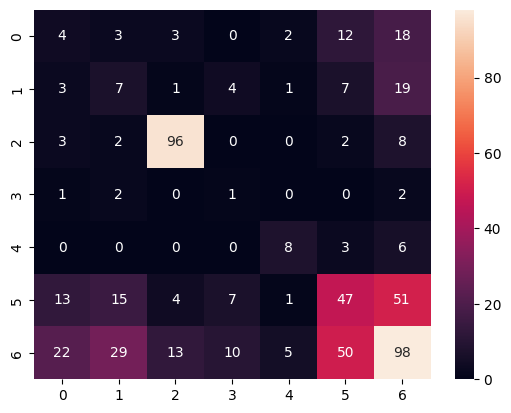

In [17]:
import seaborn as sns

sns.heatmap(construct_confusion_matrix(test_y, y_pred), annot=True)


### Calculating Accuracy, Precision Recall and F1 through the confusion matrix

Next up is calculating accuracy, precision, recall and F1. For this exercise you are not allowed to use the functions from sklearn, but you have to implement them yourself using the confusion matrix. Your task is to fill in the functions below, where the behaviour is similar to sklearn, where you can give in an 'average' parameter, which calculates the metrics with different weighting schemes.

**Hints**
- Try to think about precision and recall in terms of rows and columns in the confusion matrix, this should make the calculations relatively straightforward to implement in numpy.
- you can use `np.diag` to get the values on the diagonal of the confusion matrix.
- For F1 you can use the functions of precision and recall you wrote, but use the `None` option for weighting and calculate the different weights using these arrays, to avoid successive rounding errors in your results. Then use `np.nan_to_num` on the raw F1 array in case we have precision and recall both equal to 0.

In [18]:
# complete the below functions, where you implement the following types for each metric:
# None: return the metric for each label separately, thus returning an array of size num_classes
# 'macro': return the macro weighted metric
# 'micro': returns the micro weighted metric
# 'weighted': returns the class weighted metric

# As a warmup, calculate accuracy over the entire test set

# om de false positives te krijgen moet ik de rij pakken van de voorspelling van die class, en vervolgens de waarde op de positie
# die de class heeft in de TP diagonaal er van af halen.



def accuracy(confusion_matrix): 
    '''Accuracy is de hoeveelheid correcte voorspellingen gedeeld door de hoeveelheid voorspellingen '''
    
    accuracy = 0.0
    
    TP = sum(np.diag(confusion_matrix, k=0))
    total = (confusion_matrix.sum())
    
    accuracy = TP / total
    
    return accuracy

def precision(confusion_matrix, average): 
    assert average in [None, 'macro', 'micro', 'weighted']
    
    precision = 0
    index_counter = 0
    precision_array = []
    TP = np.diag(confusion_matrix, k=0)
    
    if average == None:
        
        precision_array = []
        # stap 1 iterate over de columns in de array, en check  
        "'Precision = True Positives / (True Positives + False Positives)''"
    
        for row in confusion_matrix:
            #print(row)
            TP_val = TP[index_counter]
            false_positives = sum(row) - TP_val
            precision_array.append(TP_val / (TP_val + false_positives))
            index_counter = index_counter + 1
            
        return np.array(precision_array)
    
    if average == 'macro':
    
        precision_array = []
        
        for row in confusion_matrix:
            #print(row)
            TP_val = TP[index_counter]
            false_positives = sum(row) - TP_val
            precision_array.append(TP_val / (TP_val + false_positives))
            sum_ = sum(precision_array)
            amount_of_class = len(row)
            precision_array_m = sum_ / amount_of_class
            index_counter = index_counter + 1
            
        return precision_array_m
        
    if average == 'micro':
        
        TP_array = []
        FP_array = []
        
        for row in confusion_matrix:
            #print(row)
            TP_val = TP[index_counter]
            false_positives = sum(row) - TP_val
            FP_array.append(TP_val)
            TP_array.append(false_positives)
        
        micro = (sum(FP_array) / (sum(FP_array) + sum(TP_array)))
        
        
        return micro    
    if average == 'weighted':
        
        precision_array = []
       
        for row in confusion_matrix:
            #print(row)
            TP_val = TP[index_counter]
            false_positives = sum(row) - TP_val
            precision = (TP_val / (TP_val + false_positives))
            precision_array.append(sum(confusion_matrix[:,index_counter]) * precision )
            index_counter = index_counter + 1
            
            
        print(sum(precision_array))
        print(confusion_matrix.sum())
        temp = sum(precision_array) / confusion_matrix.sum()
        
        return temp
            
    

def recall(confusion_matrix, average): 
    assert average in [None, 'macro', 'micro', 'weighted']
    
    
    index_counter = 0
    TP = np.diag(confusion_matrix, k=0)
    false_array = []
    recall_array =[]
    
    ''' Recall = True Positives / (True Positives + False Negatives) '''
    if average == None:
        
        false_array = []
        recall_array =[]
        
        for row in confusion_matrix:
            TP_val = TP[index_counter]
            column = confusion_matrix[:,index_counter]
            false_negatives = sum(column) - TP_val
            recall_array.append((TP_val / (TP_val + false_negatives)))
            index_counter = index_counter + 1
        return np.array(recall_array)
    
    
    if average == 'macro':
        ''' macro recall = sum(recall all clases) / amount of classes'''
        
        false_array = []
        recall_array =[]
        
        for row in confusion_matrix:
            TP_val = TP[index_counter]
            column = confusion_matrix[:,index_counter]
            false_negatives = sum(column) - TP_val
            recall_array.append((TP_val / (TP_val + false_negatives)))
            index_counter = index_counter + 1
            
        macro_recall = sum(recall_array) / len(TP)   
            
        return macro_recall
        
    if average == 'micro':
        ''' micro recall = TP / (TP + FN)'''
        
        false_array = []
        recall_array =[]
        
        for row in confusion_matrix:
            TP_val = TP[index_counter]
            column = confusion_matrix[:,index_counter]
            false_negatives = sum(column) - TP_val
            false_array.append(false_negatives)
            index_counter = index_counter + 1
            
        micro_recall = (sum(TP) / (sum(TP) +sum(false_array) ))   
            
        return (micro_recall)
    
    if average == 'weighted':
        
        '''weighted recall  =  (n1 * recall n1 + n2 * recall n2) /N'''
        
        false_array = []
        recall_array =[]
        
        for row in confusion_matrix:
            TP_val = TP[index_counter]
            column = confusion_matrix[:,index_counter]
            false_negatives = sum(column) - TP_val
            recall_array.append((TP_val / (TP_val + false_negatives) * len(column)))
            index_counter = index_counter + 1
            
        weighted_recall = sum(recall_array) / confusion_matrix.sum()   
            
        return (weighted_recall)
        
    
def f1(confusion_matrix, average):
    assert average in [None, 'macro', 'micro', 'weighted']
    F1 = 0.0
    
    index_counter = 0
    TP = np.diag(confusion_matrix, k=0)
    
    "F1 score = 2 * (precision * recall) / (precision + recall)"
    
    if average == None:
        recall_none = recall(confusion_matrix,average)
        precision_none = precision(confusion_matrix,average)
        
        F1 = (2 * (precision_none * recall_none) /(precision_none + recall_none))
        
        return np.array(F1)
    if average == 'macro':
        
        '''macro f1 = (f1 + f1) /n'''
        
        recall_none = recall(confusion_matrix,None)
        precision_none = precision(confusion_matrix,None)
        
     
        for row in confusion_matrix:
            
            
            print(precision_none)
        
            F1 = (2 * (precision_none * recall_none) / (precision_none + recall_none))
            print(F1)
        
            F1_macro = (sum(F1) / confusion_matrix.sum())
        
            index_counter +=1
        return(F1_macro)
    
        
    if average == 'micro':
        recall_none = recall(confusion_matrix,None)
        precision_none = precision(confusion_matrix,None)
        
        F1 = (2 * (precision_none * recall_none) /(precision_none + recall_none))
        
        
        return accuracy(confusion_matrix)
    
    
    
    if average == '''weighted''':

        recall_none = recall(confusion_matrix,None)
        precision_none = precision(confusion_matrix,None)
        weight_array = []
        F1 = (2 * (precision_none * recall_none) /(precision_none + recall_none))
        
        for row in confusion_matrix:
            column = confusion_matrix[:,index_counter]
            weight_array.append(F1[index_counter] * sum(column) / confusion_matrix.sum())
            index_counter = index_counter +1
        return(sum(weight_array) / len(TP))
    
        
    
    #WRITE YOUR CODE HERE



#accuracy(confusion_matrix)
#precision(confusion_matrix, None)
#precision(confusion_matrix, 'macro')
#precision(confusion_matrix, 'micro')
#precision(confusion_matrix, 'weighted')

#recall(confusion_matrix, None)
#recall(confusion_matrix, 'macro')
#recall(confusion_matrix, 'micro')
#recall(confusion_matrix, 'weighted')


#f1(confusion_matrix, None)
#f1(confusion_matrix, 'macro')
#f1(confusion_matrix, 'micro')
f1(confusion_matrix, 'weighted')




0.06287764389777571

In [19]:
test_matrix = np.array([[1, 2, 0],
                       [0, 3, 1],
                       [0, 5, 2]])

assert_equal(type(precision(test_matrix, None)), np.ndarray)
assert_equal(type(recall(test_matrix, None)), np.ndarray)
assert_equal(type(f1(test_matrix, None)), np.ndarray)


In [20]:
# Compute Macro, micro and weighted versions of precision, recall and F1.
# TODO: also use round to check here to make sure that we dont get small rounding differences
test_matrix = np.array([[1, 2, 0],
                       [0, 3, 1],
                       [0, 5, 2]])

assert_equal(type(precision(test_matrix, "macro")), np.float64)
assert_equal(type(recall(test_matrix, "macro")), np.float64)
assert_equal(type(f1(test_matrix, "macro")), np.float64)

assert_equal(type(precision(test_matrix, "micro")), np.float64)
assert_equal(type(recall(test_matrix, "micro")), np.float64)
assert_equal(type(f1(test_matrix, "micro")), np.float64)

assert_equal(type(precision(test_matrix, "weighted")), np.float64)
assert_equal(type(recall(test_matrix, "weighted")), np.float64)
assert_equal(type(f1(test_matrix, "weighted")), np.float64)


[0.33333333 0.75       0.28571429]
[0.5        0.42857143 0.4       ]
[0.33333333 0.75       0.28571429]
[0.5        0.42857143 0.4       ]
[0.33333333 0.75       0.28571429]
[0.5        0.42857143 0.4       ]
8.69047619047619
14


<a id="eval2" />

# Evaluate again

1.  Figure out how you can make a nice evaluation report using `sklearn`. Make such a report with `sklearn`.
2. Then make the same report using yoiur own functions. You need to add the support, and possibly more. Do that of course.

#tip: nice sklearn summary table that gives precision, recall, f1, support. Use that ;)
Also make the same report with your own functions, think about support as well

In [ ]:
#WRITE YOUR CODE HERE

<a id="cross_val" />

# Cross validation

* Do 5 fold cV for the KNN Classifier that we used in the previous exercise and the faults dataset, using the original `faults_X` and `faults_y arrays` we defined in the beginning.
* Does that make sense for the small classes? Think, experiment, look, and make a decision.
* Then run it. 
* Show for each class the distribution of the F1 values. Choose yourself how.
* Compute the confidence intervals. 
* What can you conclude?

For this exercise your are allowed to use functions from sklearn, and also use the `f1_score` from sklearn.

**Hints**
- If you calculate the F1 for each class individually, you can use a numpy array to store the results for each split, and then use numpy functions to easily calculate the confidence intervals.

Remember, we calculate confidence intervals for a class using $\mu \pm \frac{\sigma}{\sqrt{k}}$ where k is the number of folds.

In [21]:
#https://www.statology.org/k-fold-cross-validation-in-python/

from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, classification_report
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

# methode

kfold = KFold(n_splits = 5)


train_X, test_X, train_y, test_y = train_test_split( faults_X, faults_y, test_size=0.3, train_size= 0.7, random_state=0, stratify=new_df['target'])


# de variabelen voor de KFOLDs zijn faults_x en faults_Y

# predictor variabelen: is knn(faults_x) en faults_y is dan je test variabele

#y_pred = knn_predict(train_X,train_y,test_X, 5)
X_predict = knn_predict(train_X,train_y,test_X, 5)






model = LinearRegression()

# gebruik k-fold

resultaat = cross_val_score(model, train_X[:len(test_y)], test_y, scoring='neg_mean_absolute_error',cv=kfold, n_jobs=-1)

np.mean(np.absolute(resultaat))








# Don't forget about the `knn_predict` function you wrote!

#WRITE YOUR CODE HERE

KNeighborsClassifier()
Accuracy: 0.45


1.9929352552282276

In [75]:
KFold?

<a id="baselines" />

# Baselines

Next we are going to implement some very simple baselines that do not use any information from the features, but instead rely only on the label. As with the previous functions, make sure that they work for any label column, so don't hardcode things! As these functions don't rely on the input features , the only input you get is the y label column, and a parameter that specifies the number of samples in the test set.

## Majority class

* Always choose the majority class

## Random 

* With $C$ classes, let each class have $\frac{1}{C}$ chance.

## Weighted Random 

*  Let each class have $P(C)$ chance.
    * $P(C)$ = fraction of C-instances in the population.
    
## Compute 

* Make a clear table with macro, micro, and weighted versions precision, recall and F1 for these three baselines for the `faults` dataset.  Clearly indicate how and why you decided to calculate things the way you did.

In [39]:
# Majority class
from scipy.stats import mode # what does this function return, how can you use it?

def majority_class(input_labels, test_size):
    mode_val = mode(input_labels[0])
    a = mode_val[0]
    output_labels = []
    
    for i in range(test_size):
        output_labels.append(a[0])
    
    
    
    
    #WRITE YOUR CODE HERE
    return np.array(output_labels)
print(majority_class([0, 1, 0, 1], test_size=20))



[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


C:\Users\sebas\AppData\Local\Temp\ipykernel_2616\1124359645.py:5: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode_val = mode(input_labels[0])


In [40]:
assert_equal(len(majority_class([0, 1, 0, 1], test_size=20)), 20)

C:\Users\sebas\AppData\Local\Temp\ipykernel_2616\1124359645.py:5: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode_val = mode(input_labels[0])


In [49]:
from numpy.random import randint


def random(input_labels, test_size): 
    output_labels = []
    
    output_labels = np.random.randint(2, size = test_size)
    
    
    #WRITE YOUR CODE HERE
    return np.array(output_labels)

random([0, 1, 0, 1], test_size=20)

array([1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1])

In [48]:
assert_equal(len(random([0, 1, 0, 1], test_size=20)), 20)

In [72]:
# Hint: have a look at the numpy.random.choice function with a distribution
# Another hint: you can get counts of unique values with np.unique (look at the documentation)
# which you can use to the probabilities for your distribution
from numpy.random import choice

def weighted_random(input_labels, test_size):
    
    
    a = np.unique(input_labels, return_counts= True )
    b = a[1]
    c = a[0]
    d = []
    
    for a in b:
        prob = a / sum(b)
        d.append(prob)
    
    output_labels = np.random.choice(a = c,size = test_size, p = d)
    print(output_labels)
    return np.array(output_labels)

In [73]:
assert_equal(len(random([0, 1, 0, 1], test_size=20)), 20)

In [74]:
assert_equal(len(weighted_random([0, 1, 0, 1], test_size=20)), 20)

[1 1 0 0 1 0 0 1 1 0 0 1 1 0 1 1 1 0 1 0]


Now construct your table with results using the functions we just wrote above

In [ ]:
#WRITE YOUR CODE HERE

<a id ="theory" />

# Part 3: theory

The following questions are about precision, recall and accuracy.

Suppose you have a disease that occurs in 1 in a 100 people, and you have a test with an accuracy of .95. Meaning that in 95 percent of the case you correctly predict whether someone has the disease or not: The sum of the elements on the diagonal divided by the sum of all elements in the confusion matrix is .95.

1. What is de maximum (variable `maxR`) and minimal (`minR`) *recall* for the disease-class with these numbers?
2. What is de maximum (variable `maxP`) and minimal (`minP`) *precision* for the disease-class with these numbers?

**Hint** Construct a confusion matrix where you try different settings, make sure the numbers add up to the right totals.

## OLD DUTCH TEXT

Deze vragen gaan over precisie, recall en accuraatheid.

Stel je hebt een ziekte die bij 1 op de 100 mensen voorkomt. En je hebt een test met een accuraatheid van .95. Dit laatste betekent dat je in 95% van de gevallen juist voorspelt of iemand de ziekte heeft of niet. Anders gezegd: de som van de elementen op de diagonaal van de confusion matrix gedeeld door het totaal aantal elementen is .95.

1. Wat is de maximale(variabele `maxR`) en minimale (`minR`) *recall* voor de ziekte-klasse bij deze gegevens?
2. Wat is de maximale (`maxP`) en minimale (`minP`) *precision* voor de ziekte-klasse bij deze gegevens?

**Hint** Maak een confusion matrix waarin je verschillende settings uitprobeert. Zorg er steeds voor dat alles netjes optelt. 



In [23]:
minP = 0.99  # precisie
maxP = None
minR = None  # recall
maxR = None

#WRITE YOUR CODE HERE

In [ ]:
for m in {minP, maxP, minR, maxR}:
    assert 0 <= m <= 1

## Variant 

Dezelde vraag als boven, maar nu hebben 5 op de 100 mensen de ziekte en hebben we juist een accuraatheid van .99

In [2]:
#bij een populatie van 10.000 zijn de volgende getallen

minP = 0.05  # precisie
maxP = 0.99
minR = 0.83  # recall
maxR = 0.94

#WRITE YOUR CODE HERE

In [3]:
for m in {minP, maxP, minR, maxR}:
    assert 0 <= m <= 1

<a id="contag" />

# Part 4: What is worse: contagiousness of or deadliness?


Source: <https://www.nrc.nl/nieuws/2020/12/31/verdachte-virusvariant-met-opvallend-veel-mutaties-a4025804>

> What is worse: contagiousness or deadliness? At first glance you might think the second is. In the media there is thus also a sense of relief that the new variant of the virus is more more contagious, but less deadly than the existing variants. But is this justified? Adam Kucharski of the London School of Hygiene and Tropical Medicine [argued on Twitter](https://twitter.com/AdamJKucharski/status/1343567425107881986) that it is not.He gave the following numerical example

>Suppose R = 1.1. This means that on average ten people will infect eleven other people. Now suppose the generation time is 6 days i.e. it takes 6 days for those ten people to have infected these eleven people. This in 30 days this 'tree of contagion' splits 5 times, once each six days. Now suppose that of all people that become infected 0.8 percent die of the illness and the at the start we started with on day zero with 10.000 infected people. Then after one month we have $10.000 × (1,1)^5 × 0,8\% = 129$ people that have died.

>What happens when a mutation causes the virus to become 50 percent more deadly? If we will in the above formula with the changed deadliness we get the following: (1,1)^5 × (0,8\% × 1,5) = 193 $ people dying from the virus.

>Now what happens when the virus becomes 50 percent more contagious? Again, we can change the contagiousness in the formula and recalculate: $10.000 × (1,1 × 1,5)^5 × 0,8\% = 978$, meaning we now have almost a thousand people dying from the virus

>How is this possible? The deadliness of the virus is linearly correlated with the number of infrected people, while the number of infected people is related exponentially with the number of infected people, which we can also observe in the formula.

* Run the code below and try to understand what happens, do you understand why there is a difference in the number of dead in period 0, why it is the same for period 1, and why it starts to diverge after period 1?
* Check that the number of dead at the end of the month in the article is the same as the number at week 5 in the table.
* And see how we can very easily make a plot from spreadsheet data like this? We will be using this more in the coming weeks and explore even more cool ways of plotting data and results.

## Is it actually correct?
1. The formula is of course correct, however the outcome is not. Because if you have an R of 1.1 for a month you ahve had 6 'generations', and the total number of infected people is much higher than $10.000 x (1,1)^5$. Calculate how much more in the fuction `aantal_geinfecteerden_na_periodes`.

2. The same goes for the number of people that have died after a month, calculate this as well.



# OLD DUTCH VERSION
>Wat is erger: besmettelijkheid of dodelijkheid? Op het eerste gezicht denk je het tweede. In de media is dan ook opluchting te bespeuren dat het virus weliswaar besmettelijker is, maar geen ernstiger ziekteverloop veroorzaakt. Maar is dat terecht? Adam Kucharski van de London School of Hygiene and Tropical Medicine [betoogde op Twitter](https://twitter.com/AdamJKucharski/status/1343567425107881986) van niet. Hij gaf het volgende getallenvoorbeeld:

>Stel, R is 1,1. Dat wil zeggen dat tien besmette personen gemiddeld elf anderen besmetten. Stel, de generatietijd is zes dagen: het duurt zes dagen tot die tien mensen elf anderen hebben besmet, dus in 30 dagen vertakt die ‘besmettingsboom’ zich vijf keer. Stel, van alle besmette mensen overlijdt 0,8 procent. En stel, op tijdstip nul zijn 10.000 mensen besmet. Dan levert dat na een maand $10.000 × (1,1)^5 × 0,8\% = 129$ doden op.

>Wat gebeurt er dan als het virus door een mutatie 50 procent dodelijker wordt? Dan zijn na een maand $10.000 x (1,1)^5 × (0,8\% × 1,5) = 193 $
mensen overleden.

>Als het virus door een mutatie echter 50 procent besmettelijker wordt, dan ligt het dodental bijna vijf keer zo hoog: $10.000 × (1,1 × 1,5)^5 × 0,8\% = 978$ doden.


>Hoe dat kan? De dodelijkheid correleert lineair met het aantal doden, maar voor besmettelijkheid is dat verband exponentieel.

* Run onderstaande code. Snap wat er gebeurt. Snap je het verschil in aantal doden voor periode 0. En waarom is het gelijk in periode 1, en gaat het daarna (steeds sneller) uit elkaar lopen?
* Check dat het aantal doden aan het eind van de maand in het artikel hetzelfde is als in de tabel bij periode 5.
* En kijk eens hoe makkelijk je een plotje van zo'n spreadsheet maakt. Ideaal toch? Later in de cursus leren we hier meer over.

## Klopt het wel? (1pt)

1. De formule klopt natuurlijk, maar de uitkomst niet. Want als je een maand met een R van 1.1 zit heb je 6 "generaties", en dus in totaal veel meer besmette mensen gehad dan $10.000 x (1,1)^5$.  **Hoeveel meer dan?** **Bereken dat in de functie `aantal_geinfecteerden_na_periodes`.**
2. En dus hebben we na een maand ook een ander aantal overledenen.  Bereken dat eens.


,dodelijker,besmettelijker
Periode,,
0,120,80
1,132,132
2,145,218
3,160,359
4,176,593
5,193,978


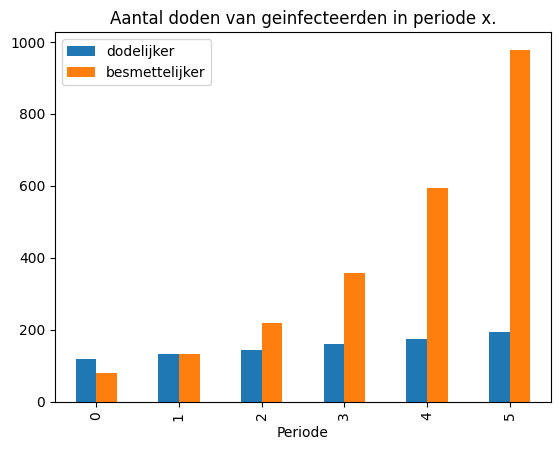

In [25]:
# zoals in het artikel
def aantaldoden(aantalbesmet=10**4,
                overlijdingsratio=.008,
                R=1.1,
                hoeveelerger=1.5,
                aantalperiodes=5):
    return {
        'dodelijker':
        round(aantalbesmet * (R)**aantalperiodes * overlijdingsratio *
              hoeveelerger),
        'besmettelijker':
        round(aantalbesmet * (R * hoeveelerger)**aantalperiodes *
              overlijdingsratio)
    }


# 50 % erger
A = {P: aantaldoden(hoeveelerger=1.5, aantalperiodes=P) for P in range(0, 6)}
A = pd.DataFrame(A).T
A.index.name = 'Periode'
A.plot(kind='bar', title='Aantal doden van geinfecteerden in periode x.')
A

In [24]:
def aantal_geinfecteerden_na_periodes(
    aantalperiodes=6,
    aantalbesmet=10**4,
    R=1.1,
):
    '''Geef het totaal aantal geinfecteerde mensen terug na aantalperiodes generaties/periodes.
    Rond af op een geheel getal.'''
    #WRITE YOUR CODE HERE


B = pd.Series({
    P: round(aantal_geinfecteerden_na_periodes(aantalperiodes=P))
    for P in range(21)
})
B.plot(kind='bar')
B

TypeError: type NoneType doesn't define __round__ method

In [ ]:
assert isinstance(aantal_geinfecteerden_na_periodes(), int)



## Altered dataframe (1pt)

Example the code above again, where we construct teh dataframe `A`. Alter the code such that you print the correct numbers acorrding to the text above, and store this in dataframe `AA`. `AA` will have the same shape and index as `A`, just different numbers

* Also observe the difference between the titles of the two plots.


## Aangepast dataframe (1pt)

Bekijk de code hierboven nog eens waarin het Dataframe `A` gemaakt werd. Pas die code aan, zodat je daarmee het dataframe `AA` maakt dat de juiste aantallen print. `AA` heeft dezelfde *shape* als `A`, en ook dezelfde index en kolom namen. Alleen de waardes zijn anders. 

* Apprecieer ook het verschil in de titels tussen de twee plotjes.

In [ ]:
AA = A  # Change with your answer

#WRITE YOUR CODE HERE

T = 'Totaal aantal doden na x periodes van 6 dagen.'
AA.plot(kind='bar', title=T)
print(AA)


#WRITE YOUR CODE HERE

In [ ]:
assert_equal(AA.shape, (6, 2))  # 2 kolommen, 6 rijen
assert_equal(list(AA.index) == list(range(6)),
             True)  # de index van AA is [0,1,2,3,4,5]

